# Overview

Started 10-8-24

Spending around 2 hours per day recreating Blip


Paper: https://arxiv.org/pdf/2201.12086


**Goal:**

To learn the engineering side of how to make a small scale version of BLIP. A small scale meaning just training over one mini-batch, and not working about making it as efficient as possible.


**Tasks:**

Read over Blip (Done 10-9-24)

Watch:

https://www.youtube.com/watch?v=X2k7n4FuI7c (Done)

and

https://www.youtube.com/watch?v=Z3knUzwuIgo (Done)


(Best to read the paper and watch others review it so you can hear their perspective and get new ideas you might have missed)

Get dataset in and make it model ready.

Create model layers and model architecture.
* Use pretrained ViT and BERT text encoder

Set up training loop.
* One pass for vision transformer, 3 for text transformers. 3 different functionalities for the 3 different losses.
* Image-Text Contrastive Loss (ITC) for unimodal encoder
* Image-Text Matching Loss (ITM) for imagegrounded text encoder
* Language Modeling Loss (LM): for the imagegrounded text decoder
* AdamW, weight decay .5

**Dataset:**

https://huggingface.co/datasets/diffusers/pokemon-gpt4-captions

**follow up:**
https://arxiv.org/pdf/1904.09751 nuclious sampling

----------------------------------------------------------------

Paper snippits:

* Don't discount how much noise can affect training poorly.

* before this paper VL models having understanding based-tasks and generative tasks together was difficult, the mixure of encoder-decoder in their architrecture allowed it

* Capfilt as self knowledge distillation is interesting. Distilling knowlegde through better captions and less noise, doesn't require same classes.

* Synthetic captions worked well for their pretraining

* Image-Text Contrastive Loss (ITC) aligns feature space of image and text transformer. loss from this paper https://arxiv.org/abs/2107.07651

* Image-Text Matching Loss (ITM): aims to learn text-image alignment. Binary classification, predicts if image-text pair is positively or negatively matched given their multimodal feature. Uses hard negative mining for contrastive loss introduced in paper above in ITC.

* Language Modeling Loss (LM) tries to generate text given an image. cross entropy loss for autoregressive text likelihood maximalization label smoothing of .1

* in Capfilt both filter and captioner intialized from pretrained BLIP model


* text encoders and decoders share params except for SA layers. paper says differences in encoder and decoder tasks best captured during self attention layers. other layers (Embed, CA, FFN) perform similarily and benefit rom multi-task learning when shared. Also improves training efficiency.

* Nucleus sampling improved caption perforamnce with more diversity over beam search

* For model architecture not every tasks compliments each other, so be careful when constructing you model and sharing parameters (from interview with authors video)
--------------------------------------------------------------
Random notes:

With this dataset CapFilt isn't really necessary, but keep it in mind for other works.

Coding from papers is like a challenging school assignment where the spec is really long and slightly rough to understand, if that makes approaching implementations easier.

-----------------------------------------------------------------

Final thoughts:
Project ended up being two paper recreations in one.
Took longer to code losses than I thought.

In [ ]:
pip install datasets

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
import transformers
%matplotlib inline

# Dataset Exploration

----------------------------------------------------------------

In [ ]:
from datasets import load_dataset

ds = load_dataset("diffusers/pokemon-gpt4-captions")

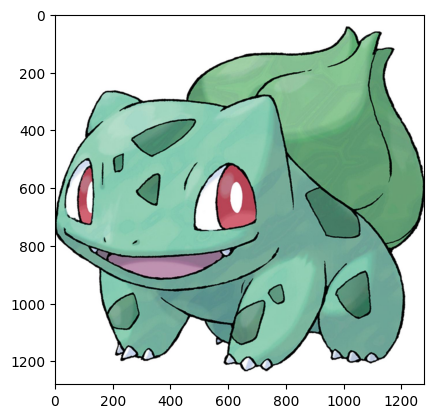

In [5]:
first_img = ds['train']['image'][0]
second_img = ds['train']['image'][1]
third_img = ds['train']['image'][2]
plt.imshow(first_img)

In [6]:
img = np.array(first_img)
img2 = np.array(second_img)
img3 = np.array(third_img)
img.shape

(1280, 1280, 3)

In [7]:
img3.shape #different sized images

(789, 789, 3)

In [8]:
img_batch = [img,img2,img3]

In [9]:
first_text = ds['train']['text'][0]
first_text

'A cheerful Bulbasaur ready for its next Pokémon adventure.'

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224", use_fast=True)
ViTmodel = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")

In [11]:
# process the few images and put them in a batch, hardcoded 3 images for testing purposes
first = True
pt_img_batch = []
for i in img_batch:
  sized_img = processor(i, return_tensors="pt")
  sized_img = sized_img['pixel_values']
  if first:
    pt_img_batch = sized_img
    first = False
  else:
    pt_img_batch = torch.vstack((pt_img_batch,sized_img))

In [12]:
pt_img_batch.shape

torch.Size([3, 3, 224, 224])

In [13]:
ViTmodel(pt_img_batch) # Logits of I'm assuming complete nonsense since the model probably doesn't have pokemon classier head on right now

ImageClassifierOutput(loss=None, logits=tensor([[ 1.0310,  1.3764,  0.5478,  ...,  2.5644,  2.1508,  0.5907],
        [-0.2021,  1.2215, -1.1037,  ...,  0.5500,  1.9552,  1.8086],
        [ 0.8291,  1.8784,  0.1577,  ...,  1.1798,  0.5392,  0.3820]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [14]:
# https://stackoverflow.com/questions/52397513/what-is-type-u12
test_img = processor(img, return_tensors="pt")
test_img = test_img['pixel_values']
test_img.shape


torch.Size([1, 3, 224, 224])

# Vision Model

_____________________________________________________________

In [15]:
ViTmodel

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [16]:
# I think in the paper they combine the whole hidden layer of the ViT into the ITC loss,
# so I am going to pop off the classification head from the [CLS] token and have the model just give the whole hidden layer output
# https://discuss.huggingface.co/t/customising-pretrained-segformer/24674/4
#https://stackoverflow.com/questions/75931144/change-the-number-of-layers-of-a-pretrained-huggingface-pegasus-model-used-for-c
# https://stackoverflow.com/questions/61323621/how-to-understand-hidden-states-of-the-returns-in-bertmodelhuggingface-transfo
# Double checking if I even need to do this with https://arxiv.org/pdf/2107.07651

hidden_out = ViTmodel(test_img, output_hidden_states=True)
hidden_out['hidden_states'][-1].shape #last hidden state, I don't think layernorm is applied to this yet

torch.Size([1, 197, 768])

In [17]:
hidden_out2 = ViTmodel(pt_img_batch, output_hidden_states=True)
hidden_out2['hidden_states'][-1].shape

torch.Size([3, 197, 768])

# ITC and ITM loss

https://arxiv.org/pdf/2107.07651 ALign BEfore Fuse (ALBEF)

Admittedly I didn't even initally check if I needed the hidden_state output, before I made sure I could get it above, but getting the hidden state seems useful to remember so even if I don't I'm going to keep it up there for future reference.

-------------------------------------------

**Paper notes:**

10-11-24

* Paper claims previous attempts to encode both images and text into same space to learn from works but not great because they were not aligned in space. They introduce new contrastive loss to align them before fusing them together in space. Works much better than other methods on image-text retrival and VQA tasks

* Doesn't need annotating boxes or high resolution images

* Introduces momentum distillation for training from noisy internet data

* Old way to do it had object detectors scan for image features, then encoder fused those features with text tokens. Problem was text and images had own spaces so it was tough for multimodel encoder to connect them

* ALBEF encodes text and images indepdently. use multi-modal encoder to fuse image features with text features through cross-modal attention.

* ITC loss on unimodal encoders to align images and text making cross modal encoding easier, improves unimodals semantic understanding of images and text, and learns a common low dimensional space to embed images and text which helps image-text matching (ITM) find better samples for hard negative mining

* ITC and their momentum maximize lower bound on mutal information, making their momentum model basically just selecting a different view of the image-text pair, makeing ALBEF learn image-text relationships which are invarient to semantic-perserving translations (this was a bit hard for me to parse, I don't really know what mutual information is so I am going to look it up, but I get the gist of what this is trying to say, same-text image pair from different views should have ALBEF behaving the same way)

* Their momentum  distillation is like an online self distilation, temporal ensemble of student is used as teacher.

* For their ITC loss they have queues to store recent image-text pairs representations from their unimodal momentum encoder

* ITM, uses their multimodal encoders embedded CLS token as representation of image-text pair, they feed it a fully connected layer then to softmax to predict two class probability. label is 2d one-hot vector, uses coss-entrophy for loss between predicted and label

* Defines softmax-normalized image-to-text and text-to-image
similarity, uses it to get hard negatives for ITM. For each image in batch they sample a negative text using constrastive simularity distribution where texts more similar to image have higher chance to be sampled. Also sample one hard negative image for each text

* Add 3 losses together to get total loss

* Momentum model is an evolving teacher which generate pseudo targets to learn from. during training trains model so model matches momentum model.

* Why fine-tune on higher resolution images? Why not go to even higher resolution images? Their momentum queue is  65,536, seems huge, but I did read you need a large amount of samples for constrative learning to really work. Also most models are being trained on/for everything under the sun.

* They maximize mutual informqation by minimizing InfoNCE loss. Minimizing ITC is maximizing a symmetric version of infoNCE, making ITC consider Images and text as two views of the same pair, and trains unimodal encoders to  maximize MI between text and images for the positve pairs.




## Basic setup and conceptual checks for ITC loss

see page 3 of the paper

https://www.youtube.com/watch?v=68dJCDyzB0A InfoNCE

* Point is to estimate normalizing constant?

* boils down to logistic loss

* when designing your own loss function test it against others to see if it works. Or even better do manual back-propagation through it to get more insights

https://www.youtube.com/watch?v=eJIp_mgVLwE Mutual Information

* way of finding how much variable explains data you want to predict for discrete case data, r^2 is the continous case. How closely related two variables are. How change in one variable is related to change in another

* when a variable is continous make bins for it and then act like its discrete

* Can be derived from entrophy.

https://www.youtube.com/watch?v=jDzuGEcnRkA constrastive loss Stanford lecture

* Hinge loss to stop negative contrastive pairs from getting pushed to negative infinity

* left off 13:39


-------------------------------

Notes:

10-17-24: I will say on page 3 they do the similarity function calculation with the momentum average features, but it seems like when they do the softmax-normalized image-to-text similarity they use the in batch texts. Why show the momentum features calculation then? My implementation uses the batch texts instead of a momentum average features text. I have not looked at how they coded this yet, but this is my question after just reading the paper and trying to implement it.

In [18]:
# Vision setup
hidden_out = ViTmodel(test_img, output_hidden_states=True)
last_hidden = hidden_out['hidden_states'][-1] #last hidden state, I don't think layernorm is applied to this yet
print(last_hidden.shape)
v_cls = last_hidden[0,0,:] #cls token for vision-output
v_cls.shape

torch.Size([1, 197, 768])


torch.Size([768])

In [19]:
v_cls.dtype

torch.float32

In [ ]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------
# text setup
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained("bert-base-uncased")

In [21]:
first_text

'A cheerful Bulbasaur ready for its next Pokémon adventure.'

In [22]:
#Making sure tokenizer adds CLS token to front
#https://discuss.huggingface.co/t/does-autotokenizer-from-pretrained-add-cls-tokens/4056
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [23]:
tokens = tokenizer(first_text, return_tensors='pt')
tokens['input_ids'].shape

torch.Size([1, 14])

In [24]:
for tok in tokens['input_ids'][0]:
  print(tok, tokenizer.decode(tok) )

tensor(101) [ C L S ]
tensor(1037) a
tensor(18350) c h e e r f u l
tensor(20581) b u l b
tensor(16782) # # a s a
tensor(3126) # # u r
tensor(3201) r e a d y
tensor(2005) f o r
tensor(2049) i t s
tensor(2279) n e x t
tensor(20421) p o k e m o n
tensor(6172) a d v e n t u r e
tensor(1012) .
tensor(102) [ S E P ]


In [25]:
output = bert_model(**tokens,output_hidden_states=True)
output = output[2][6] #keeping with the ABLEF paper which uses first 6 layers for text encoding for some reason
output.shape

torch.Size([1, 14, 768])

In [26]:
w_cls = output[0,0,:]
w_cls.shape

torch.Size([768])

In [27]:
# raw ITC implementation (not in a class, just making sure all parts fit together)
# Need ficticous queus for images and text to make softmax work

v_cls = v_cls #Vision cls
w_cls = w_cls #HF is down so can't get actual w_cls. CHANGE THIS

lower_dim = 256

fake_Mgv = torch.randn(256).reshape(256,1) #what would actually be the normalized features from the momentum encoder for vision
fake_Mgw = torch.randn(256).reshape(256,1) #what would actually be the normalized features from the momentum encoder for text

tau = nn.Parameter(torch.tensor(1.2)) # I have no idea what a good inital temp param is, so setting it to this.

gv = nn.Linear(v_cls.shape[0],lower_dim) #linear transform that maps vision cls embedding to low-d representation, leaving bias on
gw = nn.Linear(w_cls.shape[0],lower_dim)

#---------------------------------------------------------------------------------------------------------------------------------------

gv_out = gv(v_cls).reshape(lower_dim,1)
gw_out = gw(w_cls).reshape(lower_dim,1)

S_IT = torch.matmul(gv_out.T,fake_Mgw) #similarity function training with the momentum features.
S_TI = torch.matmul(gw_out.T,fake_Mgv)


In [28]:
gv_out[:5]

tensor([[ 1.7070],
        [ 2.3996],
        [-3.7597],
        [ 4.8624],
        [-1.4411]], grad_fn=<SliceBackward0>)

In [29]:
print(S_IT) # simularity score (I imagine this is how this works)
print(S_TI)
#Output is complete nonsense, but expected since the fake momentum features are complete nonsense, but it does make wonder how authors warmed up the momentum to where it was usable. Also how they initalized it and the queue.
#The scores seem a bit high as well, but I am not sure what proper similarity scores look like

tensor([[16.6094]], grad_fn=<MmBackward0>)
tensor([[12.1078]], grad_fn=<MmBackward0>)


## Actual ITC loss set up and testing with small batch

10-15-24

In [30]:
# Getting a batch of 5 image and text pairs to do constrasts with

pt_img_batch = []
text_batch = []
first = True

# ideally there would be helper functions to clean this up, but just blobing it since this isn't meant as a hardcore project.
for i in range(5):
  img = ds['train']['image'][i]
  #print(img)
  img = np.array(img)
  sized_img = processor(img, return_tensors="pt")
  sized_img = sized_img['pixel_values']

  text = ds['train']['text'][i]


  if first:
    pt_img_batch = sized_img
    text_batch.append(text)
    first = False
  else:
    pt_img_batch = torch.vstack((pt_img_batch,sized_img))
    text_batch.append(text)




In [31]:
print(pt_img_batch.shape)
len(text_batch)

torch.Size([5, 3, 224, 224])


5

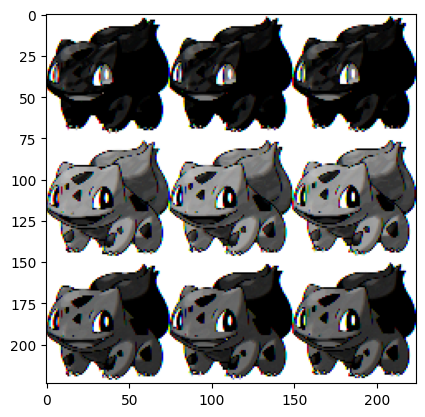

In [32]:
plt.imshow(pt_img_batch[0].reshape(224,224,3))
# I didn't know image processor made them into a grid of small images like this

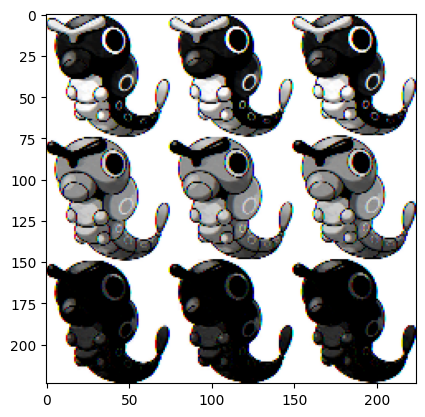

In [33]:
plt.imshow(pt_img_batch[1].reshape(224,224,3))

In [34]:
# Vision CLS tokens
hidden_out = ViTmodel(pt_img_batch, output_hidden_states=True)
last_hidden = hidden_out['hidden_states'][-1] #last hidden state, I don't think layernorm is applied to this yet
print(last_hidden.shape)
v_cls = last_hidden[:,0,:] #all cls tokens for vision-output
v_cls.shape

torch.Size([5, 197, 768])


torch.Size([5, 768])

In [35]:
v_cls

tensor([[ -2.4712,   0.2051,  11.3492,  ...,  -4.0909,   4.0729,  12.0034],
        [  5.2457,   1.9406,   5.3081,  ...,   6.3902,   2.3165,  13.0750],
        [  2.0017, -12.4612,  10.9226,  ...,  14.0509,  -2.9718,  -3.1731],
        [  1.2326,   2.9637,  10.0023,  ...,   8.2353,  -9.3355,   2.9477],
        [ -4.9279,  -2.9678,   4.0471,  ...,   7.5059,  -6.2270,   4.6723]],
       grad_fn=<SliceBackward0>)

In [36]:
# text CLS tokens
tokens = tokenizer(text_batch, return_tensors='pt',padding=True)
print('token shape: ' , tokens['input_ids'].shape)
output = bert_model(**tokens,output_hidden_states=True)
output = output[2][6] #keeping with the ABLEF paper which uses first 6 layers for text encoding for some reason
w_cls = output[:,0,:]
w_cls.shape

token shape:  torch.Size([5, 39])


torch.Size([5, 768])

In [37]:
w_cls

tensor([[-0.1627, -1.1838, -0.1305,  ..., -0.4992,  0.3412,  0.3777],
        [-0.1829, -1.0280, -0.4845,  ..., -0.4465,  0.2803,  0.4393],
        [-0.1299, -0.9616, -0.1473,  ..., -0.0670,  0.5141,  0.5335],
        [ 0.0966, -0.7452, -0.3718,  ..., -0.2670,  0.5328,  0.4018],
        [-0.0900, -1.2173, -0.3804,  ..., -0.2478,  0.2603,  0.4632]],
       grad_fn=<SliceBackward0>)

In [38]:
gw_test = nn.Linear(w_cls.shape[1],lower_dim)
out = gw_test(w_cls)
out.shape

torch.Size([5, 256])

In [39]:
#ITC loss

class ITC_Loss():
  def __init__(self,cls_batch_dim,embed_dim):
    self.tau = nn.Parameter(torch.tensor(1.2),requires_grad=True)
    self.lower_dim = embed_dim
    self.gv = nn.Linear(cls_batch_dim,lower_dim)
    self.gw = nn.Linear(cls_batch_dim,lower_dim)
    self.fake_Mgv = torch.randn(lower_dim).reshape(lower_dim,1)
    self.fake_Mgw = torch.randn(lower_dim).reshape(lower_dim,1)
    self.vcls_batch = 0 #for later
    self.wcls_batch = 0
    self.crossloss = torch.nn.CrossEntropyLoss()

  #------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

  #Helper functions

  #Similarity function between the image and text
  def S_IT(self,img_cls,text_cls):
    """ takes transformed image and text cls, then matmuls them to return S_TI """
    img_cls = img_cls.T
    S_IT = torch.matmul(img_cls,text_cls)
    return S_IT

  def S_TI(self,text_cls,img_cls):
    """ takes transformed text and img cls, then matmuls them to return S_TI """
    text_cls = text_cls.T
    S_TI = torch.matmul(text_cls,img_cls)
    return S_TI

  #softmax normalized image-to-text and text-to-image simularities, some optimizations can be done since numerator of both with share same term, this is just rough implmentation
  def P_IT(self,img_cls,text_cls,all_text_cls):
    """ image is image_cls for the function, text is associated text_cls,  all_texts is all other text cls's including text, softmax normalized image-to-text simularity"""
    numer = math.exp(self.S_IT(img_cls,text_cls) / self.tau)

    denom_sum = 0
    for i in all_text_cls:
      part = math.exp(self.S_IT(img_cls,i) / self.tau)
      denom_sum += part

    return numer / (denom_sum + .00001)

  def P_TI(self,text_cls,img_cls,all_img_cls):
    """ image is image_cls for the function, text is associated text_cls,  all_texts is all other text cls's including text, softmax normalized text-to-image simularity"""
    numer = math.exp(self.S_TI(text_cls,img_cls) / self.tau)

    denom_sum = 0
    for i in all_img_cls:
      part = math.exp(self.S_TI(text_cls,i) / self.tau)
      denom_sum += part

    return numer / (denom_sum + .00001)

  def prob_vectors(self):
    PIT_all = []
    PTI_all = []
    for i in range(self.vcls_batch.shape[0]):
      PIT_all.append(self.P_IT(self.vcls_batch[i],self.wcls_batch[i],self.wcls_batch))
      PTI_all.append(self.P_TI(self.wcls_batch[i],self.vcls_batch[i],self.vcls_batch))

    PIT_all = torch.tensor(PIT_all,requires_grad=True)
    PTI_all = torch.tensor(PTI_all,requires_grad=True)

    return PIT_all,PTI_all


  #------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

  def get_loss(self,vcls_batch,wcls_batch):
    """ Computes the ITC loss and returns it, assumes image-text pairs are at same location in their cls arrays, img[0] = text[0] """
    self.vcls_batch = self.gv(vcls_batch)
    self.wcls_batch = self.gw(wcls_batch)

    PIT_vec , PTI_vec = self.prob_vectors()

    targets = torch.tensor(np.eye(self.vcls_batch.shape[0]))

    summed = 0
    data_points = self.vcls_batch.shape[0]
    for i in range(data_points):
      IT_cross_loss = self.crossloss(PIT_vec,targets[i])
      TI_cross_loss = self.crossloss(PTI_vec,targets[i])
      summed += (IT_cross_loss + TI_cross_loss)

    expected = summed / data_points

    return (expected / 2) #paper devides expectation by 2 for some reason












In [40]:
test_loss = ITC_Loss(w_cls.shape[1],256)

In [41]:
test_loss.get_loss(v_cls,w_cls)

<ipython-input-39-fbcf150d7c77>:22: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  img_cls = img_cls.T


tensor(1.6697, dtype=torch.float64, grad_fn=<DivBackward0>)

In [42]:
# testing helper functions below
test_loss.S_IT(test_loss.vcls_batch[0],test_loss.wcls_batch[0])  #same term as S_TI when not using momentum gw_cls.

tensor(-14.4150, grad_fn=<DotBackward0>)

In [43]:
test_loss.P_IT(test_loss.vcls_batch[0],test_loss.wcls_batch[0],test_loss.wcls_batch) #Works but is of course complete jibberish due to initalization, can go very high and very low depending on initalization values.
# This gives % chance they are similar if my reasoning is correct?

0.0016169344584405655

In [44]:
test_loss.S_IT(test_loss.wcls_batch[0],test_loss.vcls_batch[0]) #same term as S_IT when not using momentum gv_cls.


tensor(-14.4150, grad_fn=<DotBackward0>)

In [45]:
P_IT = test_loss.P_IT(test_loss.wcls_batch[0],test_loss.vcls_batch[0],test_loss.vcls_batch)
P_IT

1.1710194814030713e-10

In [46]:
test_loss.prob_vectors()

(tensor([0.0016, 0.5491, 0.0033, 0.0012, 0.0622], requires_grad=True),
 tensor([1.1710e-10, 1.9526e-10, 9.9960e-01, 2.3069e-03, 2.5420e-05],
        requires_grad=True))

In [47]:
torch.tensor(np.eye(5))

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]], dtype=torch.float64)

## The Mini Blip model

10-17

I was going to build the ITM loss from the ALBEF paper but it seems simple enough that I'm just going to jump straight to the BLIP model.

todo: add right tokens to front for each part. do tokenization in forward to better control splits


10-21: Implemented text-encoder block, and MHA and FF network. Along with making it so the text gets it proper token at the start for the three different stages of the model. I need to fix the MHA next as it's currently not working right.

10-22: Fixed MHA, implemented the blocks. Trying to get ITM loss working, I'm thinking through how it is supposed to implemented now.

10-23: I just realized while working on the LM loss that there is no layer norms anywhere. Is there implicit layer norms in all these blocks and they are just such a given they didn't bother to mention them or are there really no layer norms? I'm assuming its the first but since the paper says nothing about them I don't think I'm going to put them in. I bet when I look up an implementation after this project layernorms will be everywhere. I also don't get their language modeling loss, it looks like you need to append the decode token to the whole sentence, but if it's the whole sentence there is no targets for the next token. So I am just going to assume you split up the decode sentence into chunks so the LM loss has targets and can function correctly like normal.

In [48]:
#reputting this here

pt_img_batch = []
text_batch = []
first = True

# ideally there would be helper functions to clean this up, but just blobing it since this isn't meant as a hardcore project.
for i in range(5):
  img = ds['train']['image'][i]
  #print(img)
  img = np.array(img)
  sized_img = processor(img, return_tensors="pt")
  sized_img = sized_img['pixel_values']

  text = ds['train']['text'][i]


  if first:
    pt_img_batch = sized_img
    text_batch.append(text)
    first = False
  else:
    pt_img_batch = torch.vstack((pt_img_batch,sized_img))
    text_batch.append(text)



In [49]:
# Taken from my mini-ViT implementation and NanoGPT
# https://github.com/Simon-dl/Mini-Implementations/blob/main/Mini_ViT%20.ipynb
# https://github.com/karpathy/nanoGPT/blob/master/model.py

class BiMHA(nn.Module):
  def __init__(self,embed_size,heads):
    super().__init__()
    assert embed_size % heads == 0
    self.embed_size = embed_size
    self.heads = heads
    self.head_dim = embed_size // heads
    self.attn = nn.Linear(embed_size, 3 * embed_size, bias = False)
    self.proj = nn.Linear(embed_size,embed_size)

  def forward(self,x):
    B,T,E = x.shape
    q, k, v  = self.attn(x).split(self.embed_size,dim=-1)
    q = q.view(B,T,self.heads,E // self.heads).transpose(1,2)
    k = k.view(B,T,self.heads,E // self.heads).transpose(1,2)
    v = v.view(B,T,self.heads,E // self.heads).transpose(1,2)

    y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p= 0, is_causal=False)
    y = y.transpose(1,2).contiguous().view(B,T,E)

    y = self.proj(y)

    return y

In [50]:
#Casual MHA for decoder
class CausalMHA(nn.Module):
  def __init__(self,embed_size,heads):
    super().__init__()
    assert embed_size % heads == 0
    self.embed_size = embed_size
    self.heads = heads
    self.head_dim = embed_size // heads
    self.attn = nn.Linear(embed_size, 3 * embed_size, bias = False)
    self.proj = nn.Linear(embed_size,embed_size)

  def forward(self,x):
    B,T,E = x.shape
    q, k, v  = self.attn(x).split(self.embed_size,dim=-1)
    q = q.view(B,T,self.heads,E // self.heads).transpose(1,2)
    k = k.view(B,T,self.heads,E // self.heads).transpose(1,2)
    v = v.view(B,T,self.heads,E // self.heads).transpose(1,2)

    y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p= 0, is_causal=True)
    y = y.transpose(1,2).contiguous().view(B,T,E)

    y = self.proj(y)

    return y

In [51]:
# My understanding of how cross attentions works is coming from here
# https://magazine.sebastianraschka.com/p/understanding-and-coding-self-attention
# Queries from the text embedding, Keys and values from the image embedding

class CrossMHA(nn.Module):
  def __init__(self,embed_size,heads):
    super().__init__()
    assert embed_size % heads == 0
    self.embed_size = embed_size
    self.heads = heads
    self.head_dim = embed_size // heads
    self.Q = nn.Linear(embed_size, embed_size, bias = False)
    self.K = nn.Linear(embed_size, embed_size, bias = False)
    self.V = nn.Linear(embed_size, embed_size, bias = False)
    self.proj = nn.Linear(embed_size,embed_size)

  def forward(self,text,image):
    #Text
    B,T,E = text.shape
    q = self.Q(text)
    q = q.view(B,T,self.heads,E // self.heads).transpose(1,2)

    #Image
    mB,P,Em = image.shape #batch, patches, embed
    k = self.K(image)
    v = self.V(image)
    k = k.view(mB,P,self.heads,Em // self.heads).transpose(1,2)
    v = v.view(mB,P,self.heads,Em // self.heads).transpose(1,2)

    y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p= 0, is_causal=False) #
    y = y.transpose(1,2).contiguous().view(B,T,E)

    return y

In [52]:
class FeedForward(nn.Module):
  def __init__(self,embed_size,higher_dim = 1024):
    super().__init__()
    self.ff = nn.Sequential(
    nn.Linear(embed_size,higher_dim, bias=False),
    nn.GELU(),
    nn.Linear(higher_dim,embed_size,bias=False)
    )

  def forward(self, x):
    return self.ff(x)


In [53]:
class TextEncoderBlock(nn.Module):
  def __init__(self,Bi_self_atten_block,ff_block):
    super().__init__()
    self.bi_atten = Bi_self_atten_block
    self.feedforward = ff_block

  def forward(self,x):
    x = x + self.bi_atten(x)
    x = x + self.feedforward(x)
    return x




In [54]:
class ImageTextEncoderBlock(nn.Module):
  def __init__(self,atten_block,cross_attn_block,ff_block):
    super().__init__()
    self.bi_atten = atten_block
    self.cross_block = cross_attn_block
    self.feedforward = ff_block

  def forward(self,text,image):
    x = text + self.bi_atten(text)
    x = x + self.cross_block(text,image)
    x = x + self.feedforward(x)
    return x

In [55]:
class ImageTextDecoderBlock(nn.Module):
  def __init__(self,atten_block,cross_attn_block,ff_block):
    super().__init__()
    self.cas_atten = atten_block
    self.cross_block = cross_attn_block
    self.feedforward = ff_block

  def forward(self,text,image):
    x = text + self.cas_atten(text)
    x = x + self.cross_block(text,image)
    x = x + self.feedforward(x)
    return x

In [56]:
#https://stackoverflow.com/questions/53980031/pytorch-custom-loss-function
# @markdown I don't see how this doesn't just degenerately start predicting true for everything.
# @markdown To be more descriminative it would need not aligned pairs right? But I don't know how that would work with the model architecture. So I am confused and implementing it as is.

class ITMLoss(nn.Module):
  def __init__(self,embed_size):
    super().__init__()
    self.shrink = nn.Linear(embed_size,2)
    self.soft = nn.Softmax()
    self.cross_ent = nn.CrossEntropyLoss()

  def forward(self,x):
    enc_tokens = x[:,0,:]
    B = x.shape[0]
    p_itm = self.soft(self.shrink(enc_tokens))
    targets = np.zeros(B*2).reshape(B,2)
    targets[:,0] = 1 # becomes a 5,2 matrix with all ones in first column for "true" target alignment
    targets = torch.Tensor(targets)
    out = self.cross_ent(p_itm,targets) #if I read the docs right it should reduce by mean over the mini-batch out the box
    return out



In [57]:
def Toks_Lm_Ready(tokens):
    """Takes in processed BERT tokens, splits them apart into data and targets, returns data (as BatchEncoding object ) which can go into transformer and targets (Tensor) which will be used for LM loss"""
    toks = tokens['input_ids']
    tok_type = tokens['token_type_ids']
    attn_masks = tokens['attention_mask']


    targets = toks[:,1:]

    new_toks = toks[:,:-1]
    new_tok_type = tok_type[:,:-1]
    new_atten = attn_masks[:,:-1]


    data = {
        'input_ids':new_toks,
        'token_type_ids':new_tok_type,
        'attention_mask':new_atten,
            }
    data = transformers.tokenization_utils_base.BatchEncoding(data)

    return (data, targets)

In [58]:
class MiniBLIP(nn.Module):
  """ takes in text and image batch and returns the sum of the losses as one number """
  def __init__(self):
    super().__init__()
    embed_size = 768
    self.vocab_size = 30522 #https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertConfig
    self.ViTmodel = ViTmodel
    self.BertModel = bert_model
    self.tokenizer = tokenizer

    #Other tokens, cls is baked into tokenizer
    self.enc_token = nn.Parameter(torch.zeros(1, embed_size))
    self.enc_token = nn.init.trunc_normal_(self.enc_token, std = .02)
    self.dec_token = nn.Parameter(torch.zeros(1, embed_size))
    self.dec_token = nn.init.trunc_normal_(self.dec_token, std = .02)

    self.FF = FeedForward(embed_size, 4 * embed_size) #I'm pretty sure if I define it once here and reuse it different blocks it reuses its weights right?
    self.bi_atten = BiMHA(embed_size, 4)
    self.cross_attn = CrossMHA(embed_size, 4)
    self.caus_attn = CausalMHA(embed_size, 4)

    self.text_enc = TextEncoderBlock(self.bi_atten,self.FF)
    self.img_txt_enc = ImageTextEncoderBlock(self.bi_atten,self.cross_attn,self.FF)
    self.img_txt_dec = ImageTextDecoderBlock(self.caus_attn,self.cross_attn,self.FF)
    self.lm_head = nn.Linear(embed_size,self.vocab_size)

    self.ITC_Loss = ITC_Loss(embed_size,256) #256 chosen by ALBEF paper
    self.ITM_loss = ITMLoss(embed_size)
    self.cross_ent = nn.CrossEntropyLoss()





  def forward(self,images,texts):
    """Assumes images are pre-processed but corresponding captions have not yet been tokenized, computes and returns the combined 3 losses"""

    img_hidden_out = ViTmodel(images, output_hidden_states=True)
    vis_output = img_hidden_out['hidden_states'][-1]
    v_cls = vis_output[:,0,:]

    toks = self.tokenizer(texts,return_tensors='pt',padding=True)
    embd_output = bert_model(**toks,output_hidden_states=True)
    embd_output = embd_output[2][0]
    #-------------------------------------------------------------------------
    #Split into the 3 sperate text batches, cls,encoder,decoder
    w_enc = embd_output.clone()
    w_cls = embd_output[:,:,:]

    for i in range(len(texts)):
      w_enc[i][0] = self.enc_token #replace cls with enc token
    #-------------------------------------------------------------------------
    #ITC loss
    w_cls = self.text_enc(w_cls)
    w_cls = w_cls[:,0,:]

    itc_loss = self.ITC_Loss.get_loss(v_cls,w_cls)
    #--------------------------------------------------------------------------
    #ITM loss
    w_enc_out = self.img_txt_enc(w_enc,vis_output)

    itm_loss = self.ITM_loss(w_enc_out)
    #--------------------------------------------------------------------------
    # Language model loss (LM loss)
    # Have to rerun bert_model for truncated tokens, I don't know a better way of doing this yet
    new_toks, targets = Toks_Lm_Ready(toks)
    dec_output = bert_model(**new_toks,output_hidden_states=True)
    w_dec = dec_output[2][0]
    for i in range(len(texts)):
      w_dec[i][0] = self.dec_token


    w_dec_out = self.img_txt_dec(w_dec,vis_output) #(B,T,E)
    logits = self.lm_head(w_dec_out) # now (B,T,vocab_size)

    B,T,V = logits.shape
    targets = targets.contiguous().view(B*T)
    logits = logits.view(B*T, self.vocab_size)
    LM_loss = self.cross_ent(logits,targets)

    #------------------------------------------------------------------------

    total_loss = itc_loss + itm_loss + LM_loss
    print(f'itc loss: {itc_loss}, itm loss: {itm_loss}, LM loss: {LM_loss}, total_loss: {total_loss}')
    return total_loss









In [59]:
mini_blip = MiniBLIP()
#@markdown The loss is dominated by the language model cross entrophy loss, which seems reasonable, now the model will focus on squishing that first
#@markdown The only thing I don't know is if that is an okay inital starting loss for a LM with BERT's vocab size or if it is too high, it seems very high to me.
loss = mini_blip(pt_img_batch,text_batch)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


itc loss: 1.665096151828766, itm loss: 1.1249024868011475, LM loss: 65.08544158935547, total_loss: 67.87544022798538


### Getting sentences to have correct starting tokens before being fed to model

In [60]:
tokens = tokenizer(text_batch,return_tensors='pt',padding=True)
txt_output = bert_model(**tokens,output_hidden_states=True)

In [61]:
txt_output[2][0].shape #gets first layer of model

torch.Size([5, 39, 768])

In [62]:
txt_output[2][0][0].shape #gets first setence of first layer of model, embedded

torch.Size([39, 768])

In [63]:
enc_token = nn.Parameter(torch.zeros(1, 768)) #for classification token at beginning of embedding, 1xD
#enc_token = nn.init.trunc_normal_(enc_token, std = .02) setting to 0 to make it more noticable
enc_token.shape #Enc token
enc_token[0][:5]

tensor([0., 0., 0., 0., 0.], grad_fn=<SliceBackward0>)

In [64]:
txt_output[2][0][0][0:3][0:5] #regular cls

tensor([[ 0.1686, -0.2858, -0.3261,  ..., -0.0276,  0.0383,  0.1640],
        [ 0.5956,  0.5420,  0.0412,  ...,  0.4376,  0.5639,  0.3365],
        [-0.4620,  0.4010,  0.0562,  ...,  0.9299, -0.2122, -0.4888]],
       grad_fn=<SliceBackward0>)

In [65]:
txt_output[2][0][0][0] = enc_token
txt_output[2][0][0][0:3][0:5] #now with

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.5956,  0.5420,  0.0412,  ...,  0.4376,  0.5639,  0.3365],
        [-0.4620,  0.4010,  0.0562,  ...,  0.9299, -0.2122, -0.4888]],
       grad_fn=<SliceBackward0>)

In [66]:
# Replacing enc_tokens for whole batch.
for i in range(5):
  txt_output[2][0][i][0] = enc_token


## Testing blocks

In [67]:
sentence = txt_output[2][0][0]

In [68]:
hidden_out = ViTmodel(pt_img_batch, output_hidden_states=True)
vis_output = hidden_out['hidden_states'][-1]
tokens = tokenizer(text_batch,return_tensors='pt',padding=True)
txt_output = bert_model(**tokens,output_hidden_states=True)
txt_output = txt_output[2][0]

In [69]:
last_hidden.shape

torch.Size([5, 197, 768])

In [70]:
txt_output.shape

torch.Size([5, 39, 768])

In [71]:
cross = CrossMHA(768,4)
cross_out = cross(txt_output,vis_output)

In [72]:
cross_out.shape

torch.Size([5, 39, 768])

In [73]:
bi_attn = BiMHA(768,4)
cross = CrossMHA(768,4)
FF = FeedForward(768, 4 * 768)

imgtxt_block = ImageTextEncoderBlock(bi_attn,cross,FF)
out = imgtxt_block(txt_output,vis_output)

In [74]:
out.shape

torch.Size([5, 39, 768])

In [75]:
itm = ITMLoss(768)
loss = itm(out)

In [76]:
loss

tensor(1.3131, grad_fn=<DivBackward1>)

In [77]:
loss.backward()

In [78]:
cas_attn = CausalMHA(768,4)
imgtxt_dec_block = ImageTextDecoderBlock(cas_attn,cross,FF)
out = imgtxt_dec_block(txt_output,vis_output)

In [79]:
out.shape

torch.Size([5, 39, 768])

## Token surgery to get targets

looks like splitting up the tokens is going to be harder than I thought. maybe there is a way to split and mask them after? I don't know how autoregressive LM loss is going to work with this tokenization

----------------

10-28-24: Just gonna have to change them all manually, then put them back into HF custom datatype. Did this with Toks_Lm_Ready function below.

In [80]:
text_batch

['A cheerful Bulbasaur ready for its next Pokémon adventure.',
 'A curious Caterpie from the Pokémon series, with its large black eyes and green body featuring distinctive yellow and tan patterns, peers forward.',
 'A scheming Voltorb awaits its next battle.',
 'A friendly, smiling white orb with a rosy blush and closed eyes expresses contentment and happiness.',
 'A group of Exeggcute, the egg-themed Pokémon, clusters together with expressions of determined annoyance, one showing a glimpse of the yellow yolk where its shell is broken.']

In [81]:
toks = tokenizer(text_batch,return_tensors='pt',padding=True)

In [82]:
type(toks)

transformers.tokenization_utils_base.BatchEncoding

In [83]:
new_batch = transformers.tokenization_utils_base.BatchEncoding()

In [84]:
new_batch

{}

In [85]:
inputs = toks['input_ids'][0][0:-1] #inputs

In [86]:
data = {}
data['input_ids'] = inputs

In [87]:
data

{'input_ids': tensor([  101,  1037, 18350, 20581, 16782,  3126,  3201,  2005,  2049,  2279,
         20421,  6172,  1012,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0])}

In [88]:
new_batch = transformers.tokenization_utils_base.BatchEncoding(data)

In [89]:
new_batch

{'input_ids': tensor([  101,  1037, 18350, 20581, 16782,  3126,  3201,  2005,  2049,  2279,
        20421,  6172,  1012,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])}

In [90]:
type(new_batch)

transformers.tokenization_utils_base.BatchEncoding

In [91]:
toks['input_ids'][0][1:] #targets

tensor([ 1037, 18350, 20581, 16782,  3126,  3201,  2005,  2049,  2279, 20421,
         6172,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [92]:
toks['input_ids'][:,1:]

tensor([[ 1037, 18350, 20581, 16782,  3126,  3201,  2005,  2049,  2279, 20421,
          6172,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [ 1037,  8025, 23488, 14756,  2013,  1996, 20421,  2186,  1010,  2007,
          2049,  2312,  2304,  2159,  1998,  2665,  2303,  3794,  8200,  3756,
          1998,  9092,  7060,  1010, 12746,  2830,  1012,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [ 1037,  8040, 29122,  2075,  5285,  4263,  2497, 26751,  2015,  2049,
          2279,  2645,  1012,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [ 1037,  5379,  1010,  5629,  2317, 19607,  2007,  1037, 26851, 16688,
          19

In [93]:
def Toks_Lm_Ready(tokens):
    """Takes in processed BERT tokens, splits them apart into data and targets, returns data (as BatchEncoding object ) which can go into transformer and targets (Tensor) which will be used for LM loss"""
    toks = tokens['input_ids']
    tok_type = tokens['token_type_ids']
    attn_masks = tokens['attention_mask']


    targets = toks[:,1:]

    new_toks = toks[:,:-1]
    new_tok_type = tok_type[:,:-1]
    new_atten = attn_masks[:,:-1]


    data = {
        'input_ids':new_toks,
        'token_type_ids':new_tok_type,
        'attention_mask':new_atten,
            }
    data = transformers.tokenization_utils_base.BatchEncoding(data)

    return (data, targets)



In [94]:
toks = tokenizer(text_batch,return_tensors='pt',padding=True)
new_toks, targets = Toks_Lm_Ready(toks)

In [95]:
toks.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [96]:
new_toks.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [97]:
type(new_toks)

transformers.tokenization_utils_base.BatchEncoding

In [98]:
B,T = targets.shape

In [99]:
#https://stackoverflow.com/questions/66750391/runtimeerror-view-size-is-not-compatible-with-input-tensors-size-and-stride-a
new_target = targets.contiguous().view(B*T)

In [100]:
new_target.shape

torch.Size([190])

In [101]:
new_target

tensor([ 1037, 18350, 20581, 16782,  3126,  3201,  2005,  2049,  2279, 20421,
         6172,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,  1037,  8025,
        23488, 14756,  2013,  1996, 20421,  2186,  1010,  2007,  2049,  2312,
         2304,  2159,  1998,  2665,  2303,  3794,  8200,  3756,  1998,  9092,
         7060,  1010, 12746,  2830,  1012,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,  1037,  8040, 29122,  2075,
         5285,  4263,  2497, 26751,  2015,  2049,  2279,  2645,  1012,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,  1037,  5379,  1010,  5629,  2317, 19607,
         2007,  1037, 26851, 16688,  1998,  2701,  2159, 16783, 

In [102]:
output = bert_model(**new_toks,output_hidden_states=True)
embd_output= output[2][0]

In [103]:
B,T,E = embd_output.shape

In [104]:
fake_head = nn.Linear(E, 30522) #30522 is BERT vocab size


In [105]:
logits = fake_head(embd_output)

In [106]:
logits.shape

torch.Size([5, 38, 30522])

In [107]:
logits = logits.view(B*T, 30522)

In [108]:
logits.shape

torch.Size([190, 30522])

In [109]:
cross_ent = nn.CrossEntropyLoss()

In [110]:
pls_work = cross_ent(logits,new_target)

In [111]:
pls_work

tensor(10.3264, grad_fn=<NllLossBackward0>)

# Training loop

10-28-24

In [112]:
def get_mini_batch():
  """gets 5 random image text pairs from the dataset (with replacement), returns image_batch (as tensors), and text_batch (as list since model handles tokenization)"""

  dataset_len = len(ds['train'])
  pt_img_batch = []
  text_batch = []
  first = True


  # ideally there would be helper functions to clean this up, but just blobing it since this isn't meant as a hardcore project.
  for i in range(5):
      randint = np.random.randint(0,dataset_len)
      img = ds['train']['image'][randint]
      #print(img)
      img = np.array(img)
      sized_img = processor(img, return_tensors="pt")
      sized_img = sized_img['pixel_values']

      text = ds['train']['text'][randint]


      if first:
        pt_img_batch = sized_img
        text_batch.append(text)
        first = False
      else:
        pt_img_batch = torch.vstack((pt_img_batch,sized_img))
        text_batch.append(text)

  return pt_img_batch, text_batch

In [113]:
img_batch,txt_batch = get_mini_batch()

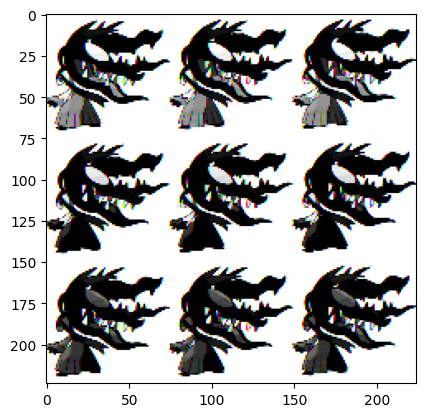

In [114]:
plt.imshow(img_batch[1].reshape(224,224,3))

In [115]:
txt_batch[1]

'Mawile, a dual-type Steel/Fairy Pokémon, stands prepared for battle with its massive jaws protruding from the back of its head, ready to unleash its power.'

In [116]:
mini_blip_model = MiniBLIP()
optimizer = torch.optim.AdamW(mini_blip_model.parameters(),lr=.0001,weight_decay=.05)

for i in range(1):
  img_batch,txt_batch = get_mini_batch()
  loss = mini_blip_model(img_batch,txt_batch) #over same mini_batch 5 times
  print(loss)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()


itc loss: 1.6666170418262483, itm loss: 0.47645488381385803, LM loss: 50.81074905395508, total_loss: 52.953820979595186
tensor(52.9538, dtype=torch.float64, grad_fn=<AddBackward0>)


# Ending thoughts

10-28-24

This mini project took longer than I thought it would. It was kind of like a Russian nesting doll. Where each thing to implement was much more work than I thought it would be and had its own challenges I didn't expect all the way down. The language modeling loss, which I thought would be the easiest, ended up taking quite a bit of time because I had to work around how Huggingface implemented their tokenizers and how BERT expects its tokens.


This implementation is correct on the surface, it does all it needs to do and gets all the losses and adds them up but it is really unstable. The losses can take on a crazy range of values and I'm not sure why. The worst offender is the LM loss.  Which I was pretty sure was implemented correctly. But also sometimes the ITC loss just completely fails on initialization which doesn't make much sense to me. Sometimes the whole colab session crashes.


There is obviously a lot I don't know, So I am not sure how to fix all these problems. But I won't be fixing them here. I am calling this project complete for now even with all the messy problems the implementations seem to bring.


So far from a perfect solution or re-implementation, but I learned a lot:

*   Contrastive loss, what it tries to accomplish and how to implement it from a paper.
*   How VLM's work at some rough level with one implementation.
*   How to use pre-made tools in certain ways to get what you need done.

To name a few things.

Obvious improvements would be to fix the random crashing, follow the data and fix the god awful LM loss start as well as make sure the ITC loss is not failing. To put the data,models and losses on the GPU for faster training. Clean up the code more to make things run faster.

But I wont be implementing those changes as I am done with this mini-project. It was a bit rough at times but I definitely think I grew a lot from it and I think I have a pretty solid foundation to start from now when I read multi-modal papers. Next time I don't think I will do all this in a colab, it ended up having a lot more parts then I thought it would.

Onto the next project!


